In [1]:
# This notebook demonstrates plotting the SalishSea domain in a vertical panel (as if it was being plotting in
# grid coordinates) but with diagonal lat,lon axis labels rather than gridX & gridY labels

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt
import netCDF4 as nc
import os
import numpy as np
import numpy.ma as ma

def get1(fn):
    with nc.Dataset(fn, 'r') as f:
        a,b,c = f.variables['Bathymetry'][:], f.variables['nav_lon'][:], f.variables['nav_lat'][:]
    return a,b,c
bp,lonp,latp    = get1('/home/mdunphy/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')

with nc.Dataset('/home/mdunphy/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc') as mm:
    tmask = mm.variables['tmask'][0,0,...]

def get(fn,var,k,tmask=None):
    with nc.Dataset(fn, 'r') as ncf:
        if len(ncf.variables[var].shape) == 4:
            v = ncf.variables[var][0,k,...]
        else:
            v = ncf.variables[var][k,...]
        if tmask is None:
            vm = ma.masked_array(v, mask=(v==0))
        else:
            vm = ma.masked_array(v, mask=1-tmask)
        print("range:",np.min(vm),np.max(vm))
        return vm

range: 7.77169898843e-300 32.0462608136


<IPython.core.display.Javascript object>


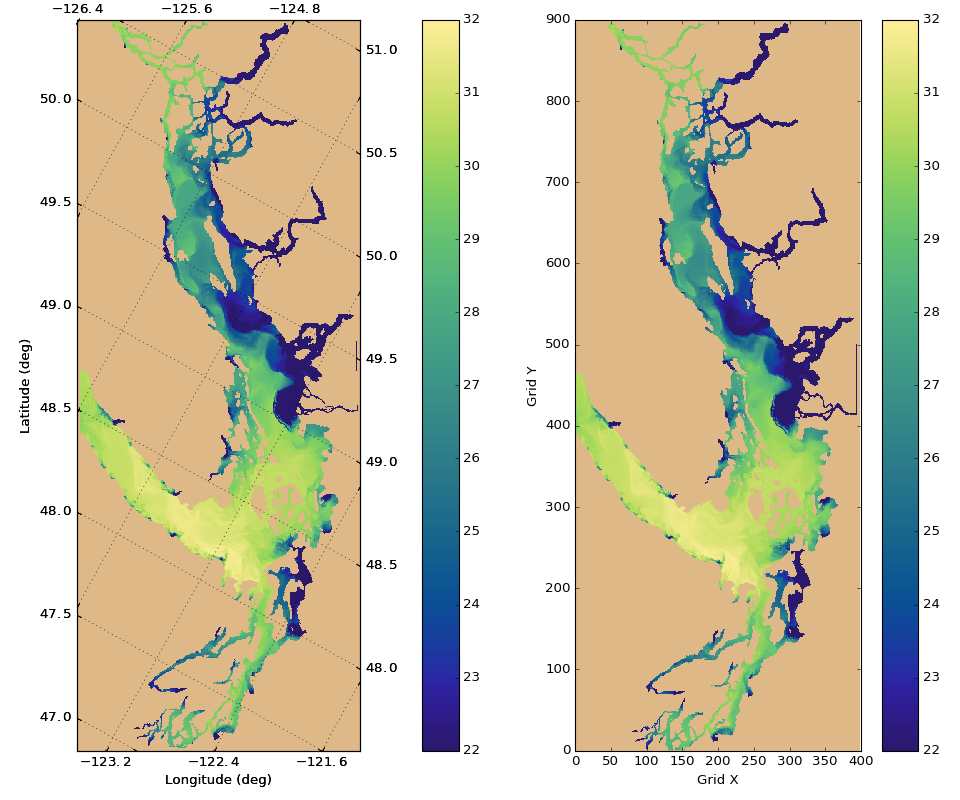

In [3]:
from mpl_toolkits.axisartist import SubplotHost, ParasiteAxesAuxTrans
from mpl_toolkits.axisartist.grid_helper_curvelinear import GridHelperCurveLinear
import matplotlib.transforms as mt
import cmocean.cm as cm

rsp  = '/results/SalishSea/hindcast/17dec14/SalishSea_00198720_restart.nc'
cmap = plt.get_cmap(cm.haline)
cmap.set_bad('burlywood')
c1,c2 = 22,32
var, k = 'sn', 0
ap = get(rsp,var,k,tmask)


fig = plt.figure(figsize=(12, 10))
fig.clf()

cmlat=np.cos(np.radians(np.mean(latp)))            # cosine of mean latitude
tr = mt.Affine2D().scale(cmlat,1).rotate_deg(-29)  # scale to handle lat/lon aspect ratio at this latitude & rotate -29deg
grid_helper = GridHelperCurveLinear(tr)
ax1 = SubplotHost(fig, 1, 2, 1, grid_helper=grid_helper)

# make ticklabels of right and top axis visible.
ax1.axis["right"].major_ticklabels.set_visible(True)
ax1.axis["top"].major_ticklabels.set_visible(True)
fig.add_subplot(ax1)

# A parasite axes with given transform
ax2 = ParasiteAxesAuxTrans(ax1, tr, "equal")
# note that ax2.transData == tr + ax1.transData
# Anything you draw in ax2 will match the ticks and grids of ax1.
ax1.parasites.append(ax2)

pc=ax2.pcolormesh(lonp,latp, ap, vmin=c1,vmax=c2, cmap=cmap)
fig.colorbar(pc, pad=0.15)

# Run the corners through the transform so we can set the transformed axis limits
pts=np.array([lonp.flatten(),latp.flatten()]).T
r=tr.transform_affine(pts)
xx,yy = r[:,0],r[:,1]
x0,x1 = np.min(xx),np.max(xx)
y0,y1 = np.min(yy),np.max(yy)
ax1.set_xlim(x0,x1)
ax1.set_ylim(y0,y1)

ax1.set_xlabel('Longitude (deg)')
ax1.set_ylabel('Latitude (deg)')
ax1.set_axis_bgcolor('burlywood')
ax1.grid(True, zorder=1)
ax1.set_aspect(1)

if 1:
    # Grid index plot at right 
    ax9 = plt.subplot(1,2,2)
    pcc=ax9.pcolormesh(ap, vmin=c1,vmax=c2, cmap=cmap)
    fig.colorbar(pcc, pad=0.05)
    ax9.set_xlabel('Grid X')
    ax9.set_ylabel('Grid Y')
    ax9.set_aspect(5/4.4)
    plt.tight_layout(pad=1,h_pad=1)
plt.draw()
plt.show()